In [91]:
import pandas as pd
import seaborn as sns
sns.set(context='poster', font_scale=1.2, style='white')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import the CSV data into Pandas dataframes

In [2]:
test_results = pd.read_csv('./test_results.csv')
user_table = pd.read_csv('./user_table.csv')

In [10]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


Background: 
Company XYZ sells a software for \$39. Since revenue has been flat for some time, the VP of
Product has decided to run a test increasing the price. She hopes that this would increase
revenue. In the experiment, 66% of the users have seen the old price ($39), while a random
sample of 33% users a higher price (\$59).
The test has been running for some time and the VP of Product is interested in understanding
how it went and whether it would make sense to increase the price for all the users.

Questions to ask:

Should the company sell its software for \$39 or $59?

The VP of Product is interested in having a holistic view into user behavior, especially
focusing on actionable insights that might increase conversion rate. What are your main
findings looking at the data?

[Bonus] The VP of Product feels that the test has been running for too long and she should
have been able to get statistically significant results in a shorter time. Do you agree with
her intuition? After how many days you would have stopped the test? Please, explain
why.

In [7]:
test_results.groupby(['price'])['converted'].count()

price
39    202672
59    114128
Name: converted, dtype: int64

In [22]:
test_results.groupby(['price', 'converted'])['converted'].count()

price  converted
39     0            198641
       1              4031
59     0            112351
       1              1777
Name: converted, dtype: int64

Okay, first I need to figure out the conversion rate at each price point.

In [5]:
conversion_rate = test_results.groupby(['price'])['converted'].mean()

In [6]:
conversion_rate

price
39    0.019889
59    0.015570
Name: converted, dtype: float64

Okay, so people who saw the lower price bought the product at a higher rate. But is it high enough to offset the difference in price?

In [7]:
lower_price_return = 39*0.019889
higher_price_return = 59*0.01557
lower_price_return, higher_price_return

(0.775671, 0.9186300000000001)

Looks like on average, we earn \$0.92 per visitor with the higher price and $0.78 per visitor with the lower price. So the company should switch.

I can formalize this analysis more by stating some hypotheses and including information about our sample size. The 'break-even' point for the new higher price is 59\*x = 39\*y, where x and y are the conversion rates at each price. So if x > 39y/59, the company should switch to the higher price. If x <= 39y/59, the company should not switch.

My null hypothesis is x <= 39y/59, which would lead to no price change.
The alternate hypothesis is x > 39y/59, which would lead to a price increase.

In [8]:
x = 0.01557
y = 0.019889
x > 39*y/59

True

In [11]:
r = test_results['converted'].mean()
diff = y - x
SE = sqrt(r*(1-r)*((1/202672.)+(1/114128.)))
diff/SE

I can test whether the rates x and y depend on the version of price using a chi-squared test for independence.

In [31]:
from scipy.stats import chi2_contingency
observed = np.array([[198641, 4031], [112351, 1777]])
#print observed
chi2, p, dof, ex = chi2_contingency(observed)
print 'chisq = {}, p = {}'.format(chi2, p)

chisq = 75.4383069939, p = 3.77004282817e-18


Well, that looks pretty convincing. We could probably have seen a difference with fewer samples, like the CEO suspects.

Let's try to plot the conversion rate over time.

In [61]:
test_results.tail()

,user_id,timestamp,source,device,operative_system,test,price,converted
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0
316799,832372,2015-03-08 17:12:33,ads_facebook,mobile,android,1,59,0


In [69]:
test_results['timestamp'].replace(to_replace=':60', value=':59', inplace=True, regex=True)

In [70]:
ordered_test_results = test_results.sort_values(by='timestamp')
ordered_test_results['timestamp'] = pd.to_datetime(ordered_test_results['timestamp'], format='%Y%m%d %H:%M:%S')

In [73]:
ordered_results_39 = ordered_test_results[ordered_test_results.price == 39].reset_index()
ordered_results_59 = ordered_test_results[ordered_test_results.price == 59].reset_index()
ordered_results_39['cum_converted'] = ordered_results_39['converted'].cumsum()
ordered_results_39['cum_rate'] = ordered_results_39['cum_converted'].div(ordered_results_39.index.values, axis=0)
ordered_results_59['cum_converted'] = ordered_results_59['converted'].cumsum()
ordered_results_59['cum_rate'] = ordered_results_59['cum_converted'].div(ordered_results_59.index.values, axis=0)

In [74]:
ordered_results_39.tail()

,index,user_id,timestamp,source,device,operative_system,test,price,converted,cum_converted,cum_rate
202667,102840,779865,2015-05-31 23:52:41,ads-google,mobile,iOS,0,39,0,4031,0.019890
202668,309275,281578,2015-05-31 23:52:41,ads-google,mobile,iOS,0,39,0,4031,0.019890
202669,142938,184420,2015-05-31 23:54:59,seo_facebook,mobile,iOS,0,39,0,4031,0.019890
202670,246297,891559,2015-05-31 23:54:59,seo_facebook,mobile,iOS,0,39,0,4031,0.019889
202671,205994,184998,2015-05-31 23:59:45,ads-bing,web,windows,0,39,0,4031,0.019889


In [86]:
ordered_results_59.head()

,index,user_id,timestamp,source,device,operative_system,test,price,converted,cum_converted,cum_rate
0,215757,813537,2015-03-02 00:04:12,ads-google,web,windows,1,59,0,0,NaN
1,166052,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59,0,0,0.0
2,223056,434444,2015-03-02 00:22:21,ads-google,web,windows,1,59,0,0,0.0
3,316162,144393,2015-03-02 00:22:21,ads-google,web,windows,1,59,0,0,0.0
4,186251,428171,2015-03-02 00:22:21,ads-google,web,windows,1,59,0,0,0.0


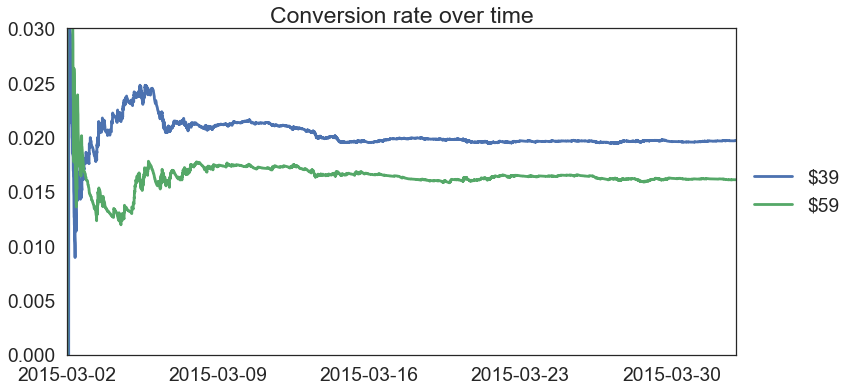

In [92]:
import datetime
enddate = datetime.datetime(2015,4,2)
startdate = datetime.datetime(2015,3,2)

fig = plt.figure(figsize(12, 6))
ax = plt.axes()
ax.plot(ordered_results_39.timestamp, ordered_results_39.cum_rate, label='$39')
ax.plot(ordered_results_59.timestamp, ordered_results_59.cum_rate, label='$59')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 0.03)
ax.set_xlim(startdate, enddate)
plt.title('Conversion rate over time')
plt.show()

Now let's look at all of the other information on our users. I'll plot conversion rate for each variable (source, device, OS) and other features like time of day and location.

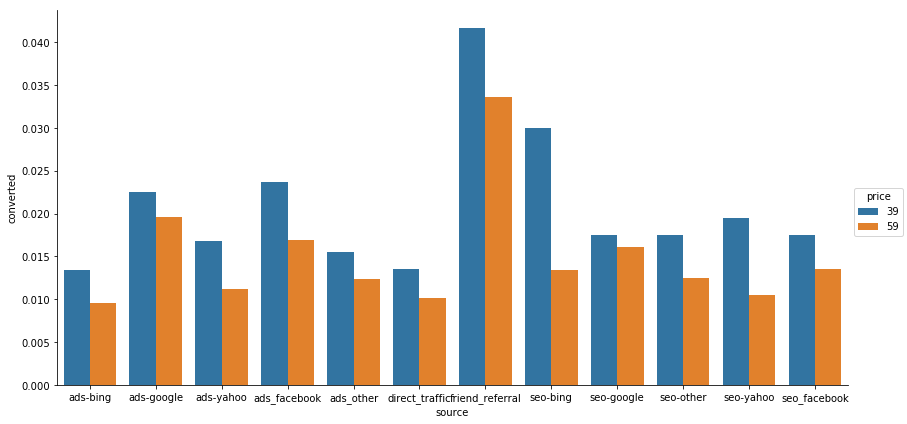

In [30]:
source_series = test_results.groupby(['price', 'source'])['converted'].mean()
source_converted = source_series.reset_index()
sns.factorplot(x='source', y='converted', data=source_converted, hue='price', kind='bar', size=6, aspect=2)
plt.show()

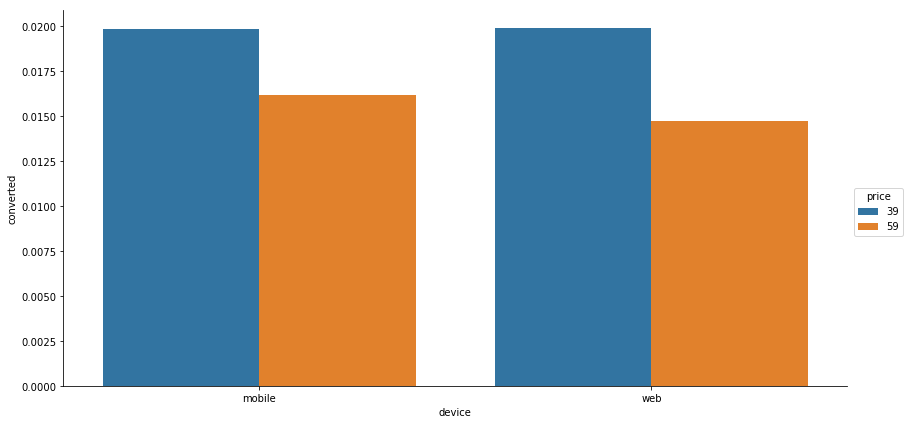

In [29]:
device_series = test_results.groupby(['price', 'device'])['converted'].mean()
device_converted = device_series.reset_index()
sns.factorplot(x='device', y='converted', data=device_converted, hue='price', kind='bar',size=6, aspect=2)
plt.show()

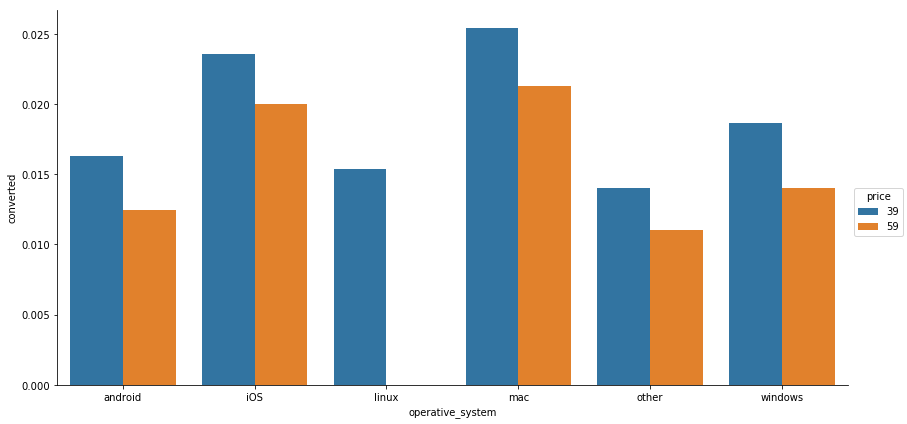

In [28]:
os_series = test_results.groupby(['price', 'operative_system'])['converted'].mean()
os_converted = os_series.reset_index()
sns.factorplot(x='operative_system', y='converted', data=os_converted, hue='price', kind='bar',size=6, aspect=2)
plt.show()